### Agentic RAG

In [90]:
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [91]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


In [92]:
urls=[
    "https://learn.microsoft.com/en-us/azure/databricks/introduction/",
    "https://learn.microsoft.com/en-us/azure/databricks/data-engineering/",
    "https://learn.microsoft.com/en-us/azure/databricks/data-sharing/"
]


#docs = loader.load()

docs = [WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://learn.microsoft.com/en-us/azure/databricks/introduction/', 'title': 'What is Azure Databricks? - Azure Databricks | Microsoft Learn', 'description': 'Learn what is the Azure Databricks Databricks Data Intelligence Platform.', 'language': 'en-us'}, page_content=" \n\n\nWhat is Azure Databricks? - Azure Databricks | Microsoft Learn\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\t\t\tSkip to main content\n\t\t\n\n\t\t\tSkip to Ask Learn chat experience\n\t\t\n\n\n\n\nThis browser is no longer supported.\n\n\t\t\t\t\t\tUpgrade to Microsoft Edge to take advantage of the latest features, security updates, and technical support.\n\t\t\t\t\t\n\n\n\t\t\t\t\t\t\tDownload Microsoft Edge\n\t\t\t\t\t\t\n\n\t\t\t\t\t\t\tMore info about Internet Explorer and Microsoft Edge\n\t\t\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n

In [93]:
doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)
doc_splits = text_splitter.split_documents(doc_list)

## Add these to vector DB

vectorstore = FAISS.from_documents(doc_splits, OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

In [94]:
retriever.invoke("What is Databricks?")

[Document(id='3fb6fd34-1371-4437-91a5-ff0e8a68e5bd', metadata={'source': 'https://learn.microsoft.com/en-us/azure/databricks/introduction/', 'title': 'What is Azure Databricks? - Azure Databricks | Microsoft Learn', 'description': 'Learn what is the Azure Databricks Databricks Data Intelligence Platform.', 'language': 'en-us'}, page_content='Edit\n\n\nShare via\n\n\n\n\nFacebook\n\n\n\n\n\nx.com\n\n\n\n\n\nLinkedIn\n\n\n\n\n\nEmail\n\n\n\n\n\n\nPrint\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nNote\n\n\n\t\t\t\t\t\tAccess to this page requires authorization. You can try signing in or changing directories.\n\t\t\t\t\t\n\n\t\t\t\t\t\tAccess to this page requires authorization. You can try changing directories.\n\t\t\t\t\t\n\n\n\nWhat is Azure Databricks?\n\n\n\n\n\n\nFeedback\n\n\n\n\n\n\n\n\n\n\n\t\t\t\t\t\tSummarize this article for me\n\t\t\t\t\t\n\n\n\n\n\n\n\n\t\t\t\tIn this article\n\t\t\t\n\nAzure Databricks is a unified, open analytics platform for building, deploying, sharing, and maintainin

In [95]:
## Retriever to retriever tools


from langchain.tools import tool

@tool
def retriever_vector_db_blog(query: str) -> str:
    """Search and return information about Azure Databricks."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_tool = retriever_vector_db_blog


In [96]:
retriever_tool

StructuredTool(name='retriever_vector_db_blog', description='Search and return information about Azure Databricks.', args_schema=<class 'langchain_core.utils.pydantic.retriever_vector_db_blog'>, func=<function retriever_vector_db_blog at 0x0000029DA9B040E0>)

In [97]:
snowflake_urls = [
    "https://docs.snowflake.com/en/index",
    "https://docs.snowflake.com/en/user-guide/data-load-overview",
    "https://docs.snowflake.com/en/user-guide/data-integration/openflow/setup-openflow-roles-login"
]

s_docs = [WebBaseLoader(url).load() for url in snowflake_urls]
s_doc_list = [item for sublist in s_docs for item in sublist]

In [98]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=80)
s_doc_splits = text_splitter.split_documents(s_doc_list)

s_vectorstore = FAISS.from_documents(s_doc_splits, OpenAIEmbeddings())
s_retriever = s_vectorstore.as_retriever()

In [99]:
## Retriever to retriever tools


from langchain.tools import tool

@tool
def retriever_vector_s_db_blog(query: str) -> str:
    """Search and return information about snowflake."""
    docs = s_retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in s_doc_list])

s_retriever_tool = retriever_vector_s_db_blog

In [100]:
tools = [retriever_tool, s_retriever_tool]

## LangGraph Workflow

In [101]:
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages

import langchainhub as hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]




In [102]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")
llm.invoke("Hello, Groq!")

AIMessage(content='<think>\nOkay, the user sent "Hello, Groq!" which seems like they\'re greeting me as Groq. First, I need to confirm if they\'re expecting me to respond as Groq, but I should clarify that I\'m Qwen. However, since they mentioned Groq, maybe they\'re testing or want a specific response. I should politely correct them and introduce myself as Qwen while being friendly.\n\nNext, I should check if there\'s any specific request in their message. They just said hello, so probably no further action needed. My response should be concise and welcoming, encouraging them to ask questions or seek help. I need to avoid using technical jargon and keep it natural. Also, make sure the tone is warm and approachable. Let me put that together.\n</think>\n\nHello! It seems there might be a bit of a mix-up—I\'m Qwen, a language model developed by Tongyi Lab. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific! 😊', additional_

In [103]:
def agent(state):
    """
    An agent that uses a Groq LLM and can access retriever tools. It will use the tools to answer questions about both Azure Databricks and Snowflake.

    Args:
        state (AgentState): The current state of the agent, including message history.
    Returns:
        str: The agent's response.
    """

    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="qwen/qwen3-32b")
    model=model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages":[response]}

In [104]:
def grade_documents(state) -> Literal["generate","rewrite"]:
    """
    Grade the documents based on their relevance to the user's query.

    Args:
        state (AgentState): The current state of the agent, including message history.
    Returns:
        Literal["generate","rewrite"]: The action to take based on the grading.
    """

    print("---CHECK RELAVANCE---")
    class grade(BaseModel):
        """Binary score for relevance check"""
        binary_score: str = Field(description='If the documents are relevant, respond with "yes". If they are not relevant, respond with "no".')

    #LLM 
    model = ChatGroq(model="openai/gpt-oss-120b")
    llm_with_tool = model.with_structured_output(grade)
    #prompt

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )



  #chain
    chain = prompt | llm_with_tool

    messages= state["messages"]
    last_message=messages[-1]

    question=messages[0].content
    docs=last_message.content

    scored_results = chain.invoke({"context": docs, "question": question})

    score = scored_results.binary_score
    if score.lower() == "yes":
        print("--- Documents are relevant----")
        return "generate"
    else:
        print("--- Documents are not relevant----")
        print(score)
        return "rewrite"


In [105]:
def generate(state):
    """
    Generate a response using the agent.

    Args:
        state (AgentState): The current state of the agent, including message history.
    Returns:
        str: The generated response.
    """

    print("--- GENERATE RESPONSE---")
    messages = state["messages"]
    question=messages[0].content
    last_message=messages[-1]
    docs=last_message.content

    #prompt
    # prompt=hub.pull("rlm/rag-prompt")
    


    model = ChatGroq(model="qwen/qwen3-32b")
    response = model.invoke(messages)
    return {"messages":[response]}

In [106]:
def rewrite(state):
    """
    Rewrite the user's query to be more specific.

    Args:
        state (AgentState): The current state of the agent, including message history.
    Returns:
        str: The rewritten query.
    """

    print("--- REWRITE QUERY---")
    messages = state["messages"]
    question=messages[0].content
    
    msg = [
        HumanMessage(content=f""" \n 
            Look at the input and try to reason about the underlying semantic intent \n 
            Here is the initial question: 
            \n ----- \n 
            {question}
            \n ----- \n
            Formulate an improved question:
            """)
    ]

    model = ChatGroq(model="qwen/qwen3-32b")
    response = model.invoke(msg)
    return {"messages":[response]}

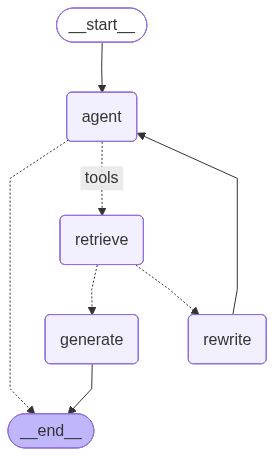

In [107]:
# Define the agent workflow
from langgraph.graph import StateGraph, START, END 
from langgraph.prebuilt import tools_condition, ToolNode

workflow = StateGraph(AgentState)

#Define the nodes 
workflow.add_node("agent",agent) #agent 
retrieve = ToolNode([retriever_tool, s_retriever_tool])
workflow.add_node("retrieve", retrieve) #retriever tools
workflow.add_node("rewrite", rewrite) #rewrite
workflow.add_node("generate", generate) #grade documents

#Define the edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    #Assess Agent decision
    tools_condition,
    {
        "tools":"retrieve",
        END:END
    },
 )

#Edges taken after the action node is called
workflow.add_conditional_edges(
    "retrieve",
    grade_documents
)

workflow.add_edge("generate",END)
workflow.add_edge("rewrite","agent")

#comppile 

graph = workflow.compile()
from IPython.display import display, Image 
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [108]:
graph.invoke({
    "messages":"Explain the data loading process in Snowflake."
})

---CALL AGENT---
---CHECK RELAVANCE---
--- Documents are relevant----
--- GENERATE RESPONSE---


{'messages': [HumanMessage(content='Explain the data loading process in Snowflake.', additional_kwargs={}, response_metadata={}, id='05d83074-38b9-4b0c-8940-8c385a1182ff'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the data loading process in Snowflake. Let me think about what I need to do here. First, I should check if there\'s a specific function provided that can help retrieve information related to Snowflake. Looking at the tools provided, there\'s one called "retriever_vector_s_db_blog" which is for searching information about snowflake. Perfect, that\'s exactly what I need here.\n\nThe user\'s query is about explaining the data loading process, so I need to make sure I use the right parameters. The function requires a "query" parameter, which in this case would be "data loading process". I should structure the tool call with that query. Let me double-check the function\'s parameters to ensure I\'m formatting it correctly. The 

In [109]:
graph.invoke({"messages":"What is Machine learning?"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is Machine learning?', additional_kwargs={}, response_metadata={}, id='419f4556-1ddd-488a-a40b-9b08979ed1f8'),
  AIMessage(content='Machine learning is a subset of artificial intelligence (AI) that focuses on building systems that can learn from data. It involves developing algorithms and statistical models that enable computers to perform tasks without being explicitly programmed for them. Instead, these systems improve their performance through experience, by analyzing patterns and making inferences from large datasets. Common applications include image recognition, natural language processing, recommendation systems, and predictive analytics.', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is Machine learning?" Let me think about how to approach this. First, I need to determine if any of the provided tools are relevant. The tools available are for searching information about Azure Databricks and Snowflake. The user\'

In [110]:
graph.invoke({
    "messages":"Explain the data loading process in databricks."
})

---CALL AGENT---
---CHECK RELAVANCE---
--- Documents are relevant----
--- GENERATE RESPONSE---


{'messages': [HumanMessage(content='Explain the data loading process in databricks.', additional_kwargs={}, response_metadata={}, id='05ee1a14-53bf-4030-ae03-0d4577ae712b'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the data loading process in Databricks. I need to explain how data is loaded into Databricks. First, I should recall the common methods used. Databricks typically uses PySpark or Spark SQL for data ingestion. They might use commands like spark.read to load data from various sources such as CSV, Parquet, or databases.\n\nWait, maybe I should check if there\'s specific information in the provided tools. The user provided a function called retriever_vector_db_blog which is for searching Azure Databricks info. Since the question is about Databricks, I should use that function. The other function is for Snowflake, which isn\'t relevant here.\n\nI should call the retriever_vector_db_blog function with the query "data loading p